# Project 2: Time Series Analysis

In [4]:
# Some important libraries to use in time sereies analysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels as statsmodels
import matplotlib.pyplot as plt
import numpy as np
from pandasdmx import Request
import pandas as pd
import os

# Setting fixed figure size
plt.rcParams['figure.figsize'] = [10, 7.5]

## Importing Lake Huron Data and Plotting it

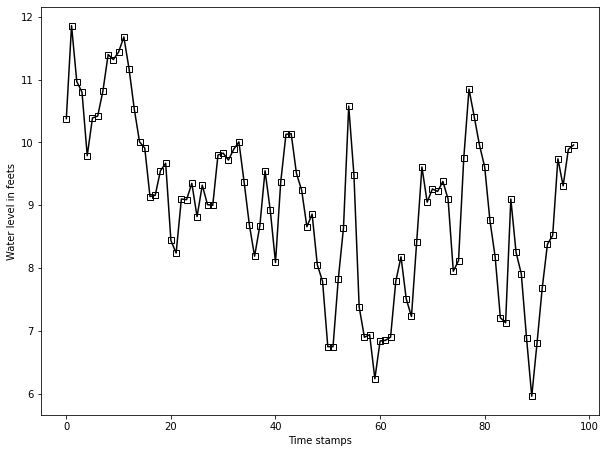

In [71]:
# Obtaining path to data and getting the data
filepath = os.getcwd()
filepath = filepath +"/Data/lakedata.xlsx"
df = pd.read_excel(filepath)

#plotting data as numpy arrays
data = df.iloc[:,0].to_numpy()
dataTime = np.arange(0,data.shape[0])
plt.figure()
plt.plot(dataTime, data,"k", marker='s', markerfacecolor='none')
plt.xlabel("Time stamps")
plt.ylabel("Water level in feets")

#save figure
plt.savefig("lakedata.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### Linear regression with Lake Huron Data for $0\leq t \leq 96$

In [91]:
V = np.stack([np.ones(dataTime.shape).T, dataTime.T, (dataTime.T)**2], axis =0).T
VFit = V[0:-1,:]
dataFit = data[0:-1]
a = np.linalg.pinv(VFit.T@VFit)@VFit.T@dataFit.T
a


array([ 1.11927234e+01, -8.68981968e-02,  6.38800778e-04])

#### Plot the linear fit

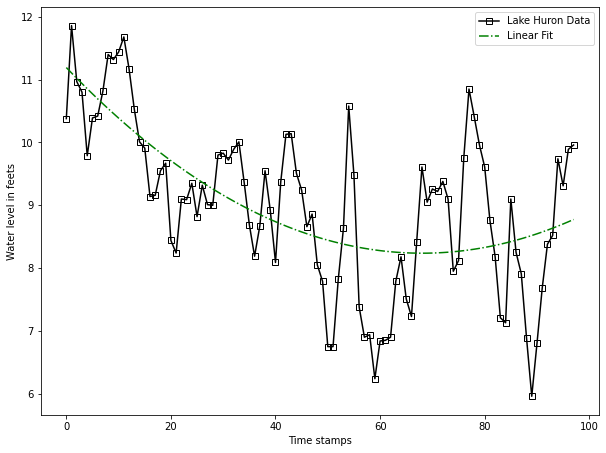

In [92]:
#plotting data as numpy arrays
xPreds = a @ V.T
plt.figure()
plt.plot(dataTime, data,  "k", marker='s', markerfacecolor='none')
plt.plot(dataTime, xPreds, 'g-.')
plt.xlabel("Time stamps")
plt.ylabel("Water level in feets")
plt.legend(["Lake Huron Data", "Linear Fit"])
#save figure
plt.savefig("lakefit.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [97]:
#predicting water level in 1972
m97 = a@[[1],[97],[97**2]]
print(m97, data[-1])

# Error
error =  np.abs(m97 - data[-1])
print(error)

[8.77407488] 9.96
[1.18592512]


#### Residual Plot

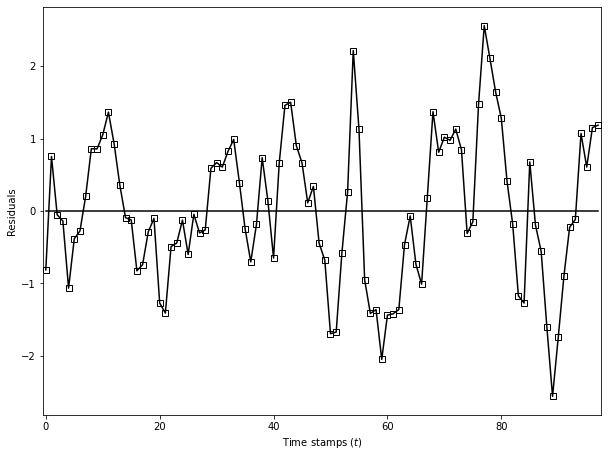

In [109]:
resds = data- xPreds
plt.figure()
plt.plot(dataTime, resds,  "k", marker='s', markerfacecolor='none')
plt.plot(dataTime, np.zeros(dataTime.shape), "k")
plt.xlabel("Time stamps $(t)$")
plt.ylabel("Residuals")
plt.xlim([dataTime[0]-0.5, dataTime[-1]+0.5])
#save figure
plt.savefig("lakefitres.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:

Agency_Code = 'ABS'
Dataset_Id =
ABS = Request(Agency_Code)
data_response = ABS.data(resource_id='ATSI_BIRTHS_SUMM', params={'startPeriod': '2016'})

#This will result into a stacked DataFrame
df = data_response.write(data_response.data.series, parse_time=False)

#A flat DataFrame
data_response.write().unstack().reset_index()

ConnectionError: HTTPSConnectionPool(host='stat.data.abs.gov.au', port=443): Max retries exceeded with url: /sdmx-json/data/ATSI_BIRTHS_SUMM?startPeriod=2016 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002B5BAD72440>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

## Moving Average Series (MA)

## Autoregressive Series (AR)

In [276]:
ar1 = np.array([1,- 0.5])
ma1 = np.array([1, 0, 0.25])
ARMA_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=1000)

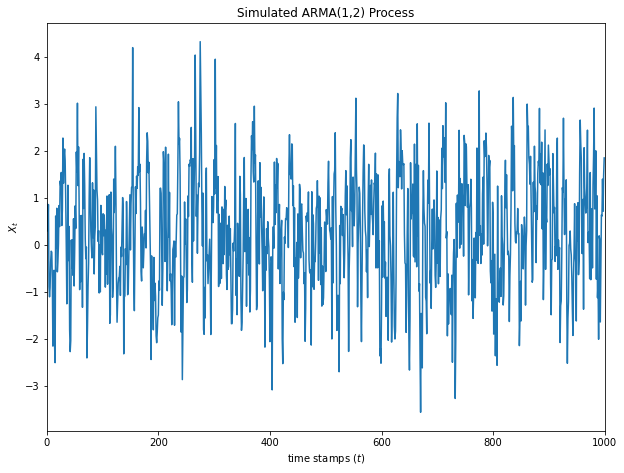

In [277]:
plt.plot(ARMA_1)
plt.title('Simulated ARMA(1,2) Process')
plt.xlim([0,1000])
plt.ylabel("$X_t$")
plt.xlabel("time stamps $(t)$")
plt.show()

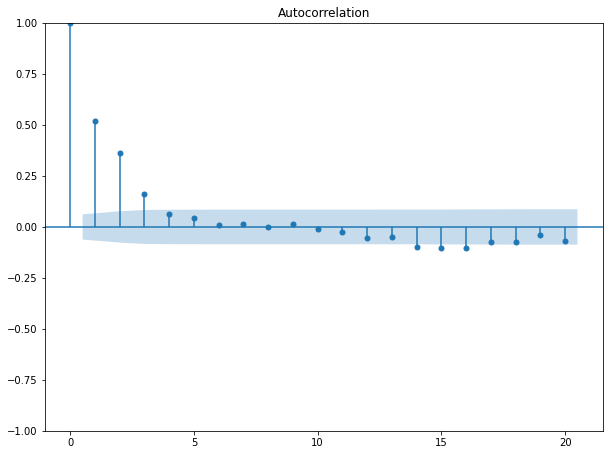

In [278]:
plot_acf(ARMA_1, lags =20)
plt.show()

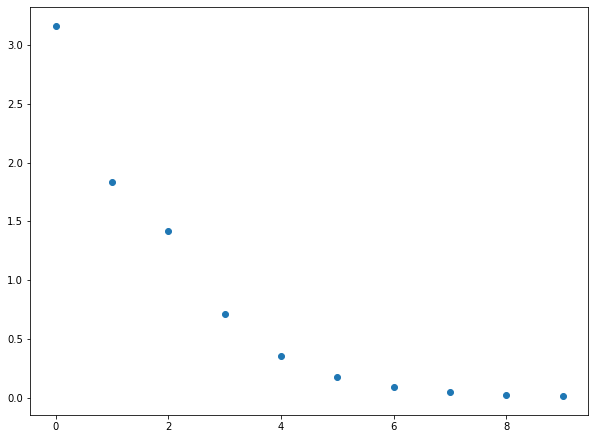

In [279]:
acvf = statsmodels.tsa.arima_process.arma_acovf(ar1, ma1, nobs=10, sigma2=2, dtype=None)
plt.scatter(range(len(acvf)),acvf)
plt.show()

Autocorrelation

In [280]:
acvf/acvf[0]

array([1.        , 0.57894737, 0.44736842, 0.22368421, 0.11184211,
       0.05592105, 0.02796053, 0.01398026, 0.00699013, 0.00349507])

Autocorrelation estimate

In [281]:
acv_setimate = statsmodels.tsa.stattools.acf(ARMA_1, nlags=20 )


In [292]:
steps = np.array([1, 10, 100, 1000, 10000, 100000, 1000000])
ARMA_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=1000)
acv_theory = np.array( statsmodels.tsa.arima_process.arma_acovf(ar1, ma1, nobs=21, sigma2=2, dtype=None))
acv_theory = acv_theory/acv_theory[0]
autocorr_rmse = []
for i in steps:
    temp_autocor =0
    for j in range(i):
        temp_autocor += statsmodels.tsa.stattools.acf(ARMA_1, nlags=20 )
    avg_tempautocor = temp_autocor/i
    autocorr_rmsetemp = np.linalg.norm(avg_tempautocor - acv_theory) / np.sqrt(len(acv_theory))  
    autocorr_rmse.append(autocorr_rmsetemp)

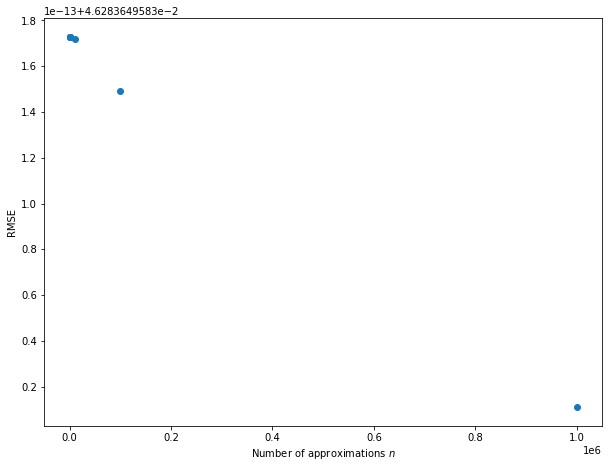

In [333]:
plt.scatter(steps, autocorr_rmse)
plt.xlabel("Number of approximations $n$")
plt.ylabel("RMSE")
plt.show()

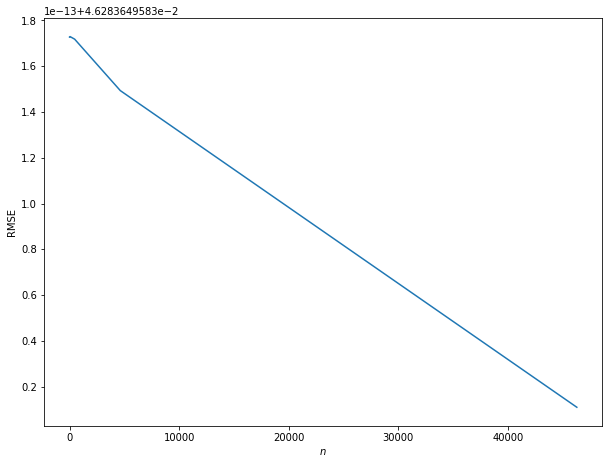

In [343]:
#Performing regression using polyfit
coeffs = np.polyfit(1/np.sqrt(steps),autocorr_rmse, deg = 1)
coeffs

#Plotting
plt.plot(coeffs[0]+coeffs[1]*steps, autocorr_rmse)
plt.xlabel("$n$")
plt.ylabel("RMSE")
plt.show()